In [15]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
device = torch.device("cpu")

# Set a random seed so later our outputs dont keep changing
torch.manual_seed(42)

In [16]:
# get tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Load gpt-2
model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [17]:
# Define agreement prompts with different syntactic structures (from paper)

# Simple agreement: subject directly adjacent to verb
prompts_simple = [
    ("The cat", "is", "are"),
    ("The cats", "are", "is"),
    ("The boy", "is", "are"),
    ("The boys", "are", "is"),
]

# Across prepositional phrase: attractor noun between subject and verb
prompts_pp = [
    ("The cat behind the cars", "is", "are"),
    ("The cats behind the car", "are", "is"),
    ("The boy near the dogs", "is", "are"),
    ("The boys near the dog", "are", "is"),
]

num_neurons = 500  # p sure the upper bound is 3072, so i can up this in future runs to check on things


In [18]:
# ok now testing both structures across all 12 layers
structures = {
    "Simple": prompts_simple,
    "PP": prompts_pp
}

layers_to_test = list(range(12))  # All 12 layers in GPT-2
all_results = {}

# print("Testing all structures across all layers...")
# print(f"Structures: {list(structures.keys())}")
# print(f"Layers: {layers_to_test}\n")

for structure_name, prompts in structures.items():
    #print(f"\n{'='*60}")
    #print(f"Testing structure: {structure_name}")
    #print(f"{'='*60}")
    
    all_results[structure_name] = {}
    
    for layer_idx in layers_to_test:
        #print(f"  Layer {layer_idx}...", end=" ")
        avg_deltas = []
        
        mlp_layer = model.transformer.h[layer_idx].mlp.c_fc

        for neuron_idx in range(num_neurons):
            deltas = []
            
            for prompt, correct, wrong in prompts:
                tok = tokenizer(prompt, return_tensors="pt").to(device)
                
                with torch.no_grad():
                    base_out = model(**tok)
                base_logits = base_out.logits[0, -1]
                base_probs = torch.softmax(base_logits, dim=-1)
                
                correct_id = tokenizer.encode(" " + correct, add_special_tokens=False)[0]
                base_corr = base_probs[correct_id].item()
                
                def intervention_hook(module, input, output):
                    output[:, :, neuron_idx] = 0.0
                    return output
                
                handle = mlp_layer.register_forward_hook(intervention_hook)
                
                with torch.no_grad():
                    int_out = model(**tok)
                
                handle.remove()
                
                int_logits = int_out.logits[0, -1]
                int_probs = torch.softmax(int_logits, dim=-1)
                int_corr = int_probs[correct_id].item()
                
                deltas.append(base_corr - int_corr)

            avg_delta = sum(deltas) / len(deltas)
            avg_deltas.append(avg_delta)
        
        all_results[structure_name][layer_idx] = avg_deltas
        max_effect = max(abs(d) for d in avg_deltas)
        print(f"Max |ΔP| = {max_effect:.6f}")

print("\n" + "="*60)
print("DONE")
print("="*60)

Max |ΔP| = 0.006058
Max |ΔP| = 0.004407
Max |ΔP| = 0.001276
Max |ΔP| = 0.000750
Max |ΔP| = 0.001804
Max |ΔP| = 0.001527
Max |ΔP| = 0.006418
Max |ΔP| = 0.003060
Max |ΔP| = 0.001648
Max |ΔP| = 0.002915
Max |ΔP| = 0.025938
Max |ΔP| = 0.012007
Max |ΔP| = 0.012256
Max |ΔP| = 0.001430
Max |ΔP| = 0.001893
Max |ΔP| = 0.001714
Max |ΔP| = 0.003567
Max |ΔP| = 0.004190
Max |ΔP| = 0.007309
Max |ΔP| = 0.006162
Max |ΔP| = 0.003015
Max |ΔP| = 0.005760
Max |ΔP| = 0.018899
Max |ΔP| = 0.024985

DONE


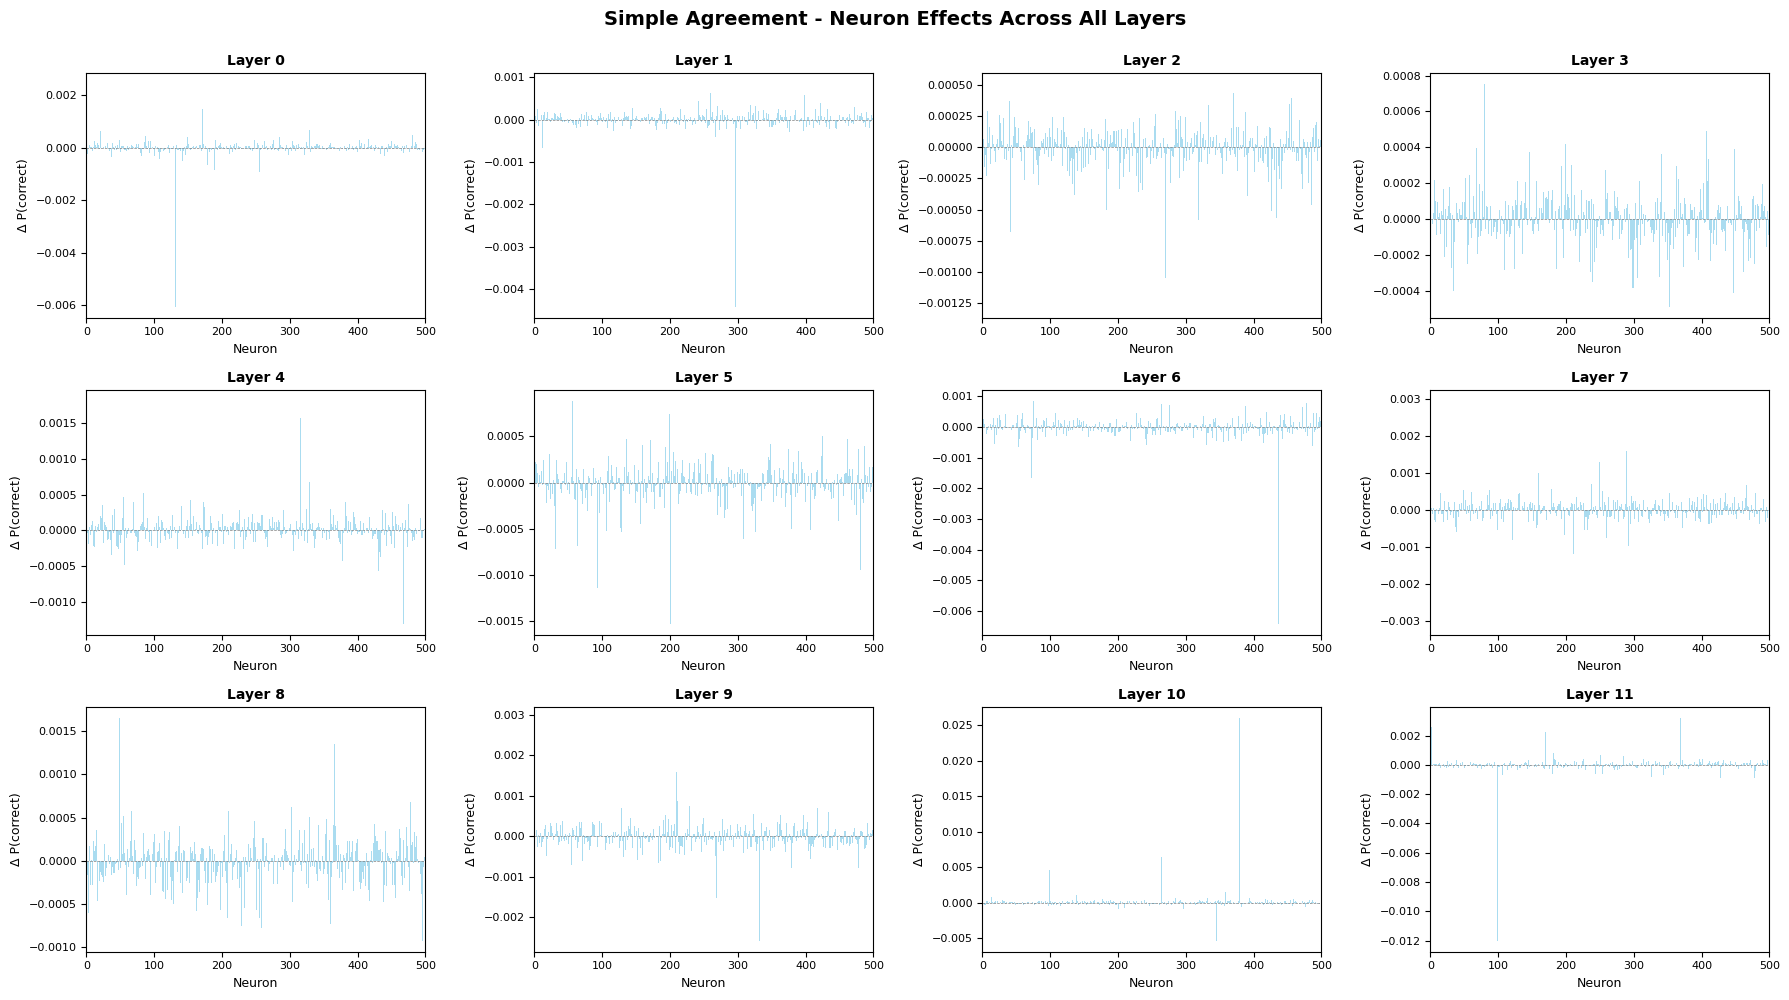

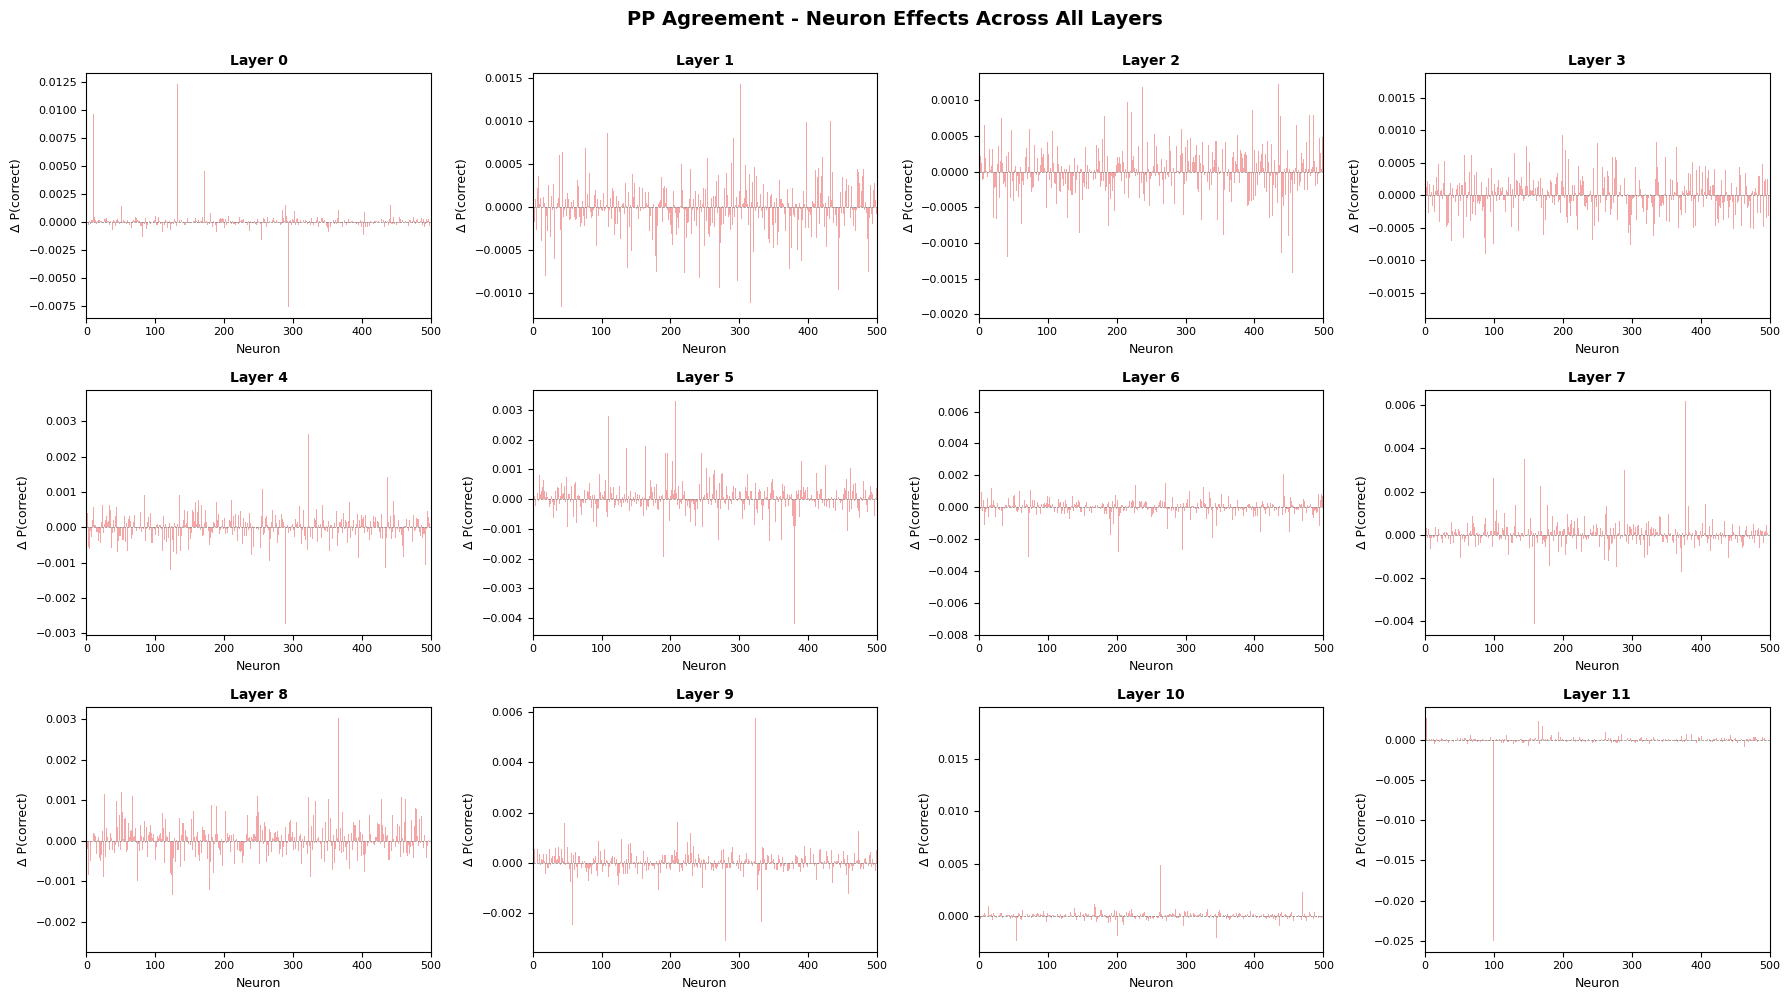

In [19]:
# bar plots for each structure

import matplotlib.pyplot as plt
import numpy as np

structure_names = list(all_results.keys())
colors = ['skyblue', 'lightcoral']

for structure_idx, structure_name in enumerate(structure_names):
    fig, axes = plt.subplots(3, 4, figsize=(18, 10))
    axes = axes.flatten()
    
    for i, layer_idx in enumerate(layers_to_test):
        ax = axes[i]
        avg_deltas = np.array(all_results[structure_name][layer_idx])
        neuron_indices = np.arange(len(avg_deltas))
        
        ax.bar(neuron_indices, avg_deltas, color=colors[structure_idx], width=1.0, alpha=0.7)
        ax.set_xlabel("Neuron", fontsize=9)
        ax.set_ylabel("Δ P(correct)", fontsize=9)
        ax.set_title(f"Layer {layer_idx}", fontsize=10, fontweight='bold')
        ax.set_xlim(0, len(neuron_indices))
        ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
        ax.tick_params(axis='both', which='major', labelsize=8)
    
    plt.suptitle(f"{structure_name} Agreement - Neuron Effects Across All Layers", 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

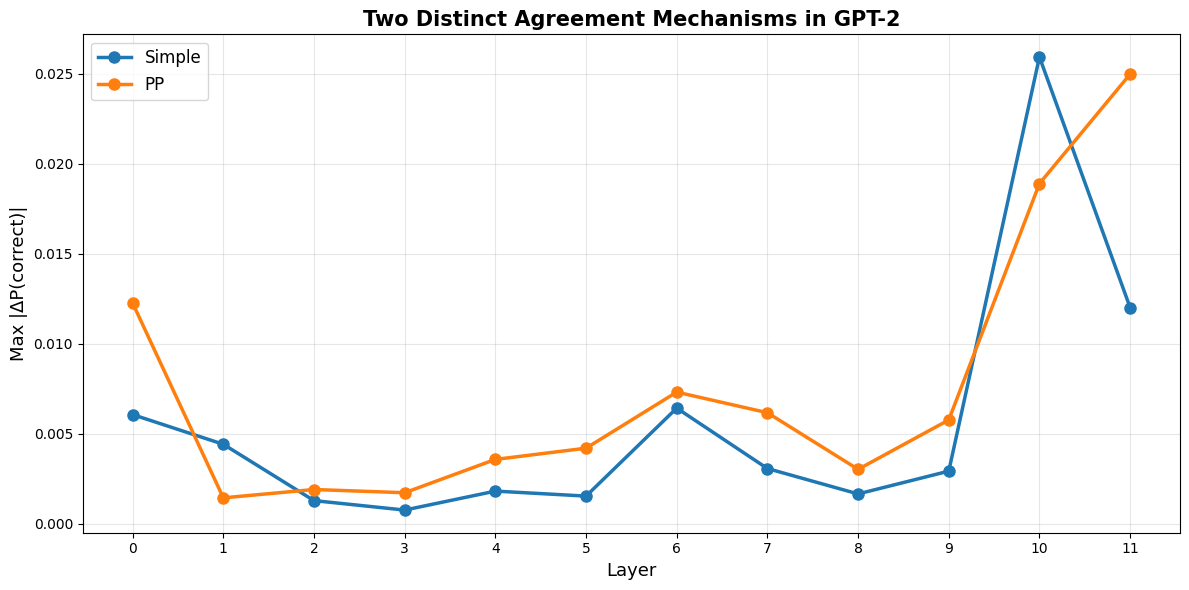


Maximum |ΔP(correct)| by each type of Structure and each Layer
Structure      L0        L1        L2        L3        L4        L5        L6        L7        L8        L9        L10       L11       
--------------------------------------------------------------------------------
Simple         0.00606   0.00441   0.00128   0.00075   0.00180   0.00153   0.00642   0.00306   0.00165   0.00291   0.02594   0.01201   
PP             0.01226   0.00143   0.00189   0.00171   0.00357   0.00419   0.00731   0.00616   0.00301   0.00576   0.01890   0.02498   


In [20]:
# line plot to compare the two structures

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(12, 6))

structure_names = list(all_results.keys())

for structure_name in structure_names:
    # Get the max absolute effect for each layer
    max_effects = [max(abs(d) for d in all_results[structure_name][layer_idx]) 
                   for layer_idx in layers_to_test]
    ax.plot(layers_to_test, max_effects, marker='o', linewidth=2.5, 
            label=structure_name, markersize=8)

ax.set_xlabel("Layer", fontsize=13)
ax.set_ylabel("Max |ΔP(correct)|", fontsize=13)
ax.set_title("Two Distinct Agreement Mechanisms in GPT-2", fontsize=15, fontweight='bold')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_xticks(layers_to_test)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*80)
print("Maximum |ΔP(correct)| by each type of Structure and each Layer")
print("="*80)

header = "Structure".ljust(15)
for layer_idx in layers_to_test:
    header += f"L{layer_idx}".ljust(10)
print(header)
print("-"*80)

for structure_name in structure_names:
    row = structure_name.ljust(15)
    for layer_idx in layers_to_test:
        max_effect = max(abs(d) for d in all_results[structure_name][layer_idx])
        row += f"{max_effect:.5f}".ljust(10)
    print(row)
